In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

df = pd.read_csv('../dataSets/training/training_20min_avg_travel_time.csv')


trajectories_train = {}
start_time  = datetime.strptime("2016-07-19 00:00:00",'%Y-%m-%d %H:%M:%S')

for idx in range(df.shape[0]):
    line = df.iloc[idx]
    route = str(line['intersection_id']+str(line['tollgate_id']))
    stime = datetime.strptime(line['time_window'][1:20],'%Y-%m-%d %H:%M:%S')
    day = (stime - start_time).days
    tw_n = (stime.hour * 60 + stime.minute)/20
    
    if route not in trajectories_train.keys():
        trajectories_train[route] = np.zeros(72*91).reshape(91,72)
    trajectories_train[route][day][tw_n] = line['avg_travel_time']

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/liuzhisheng/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/liuzhisheng/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/liuzhisheng/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/liuzhisheng/anaconda/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/liuzhisheng/anaconda/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/liuzhisheng/anaconda/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename

IndexError: string index out of range

In [2]:
train_A2 = trajectories_train['A2'].flatten() ##把每个时间窗平铺成时间轴数据

In [3]:
print train_A2.shape

(6552,)


## 使用ARMA

In [4]:
import numpy as np
from scipy import stats
import pandas
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot

In [5]:
dta = pandas.DataFrame(data = train_A2)

In [6]:
from datetime import datetime
from datetime import timedelta

delta = np.array([timedelta(minutes=i) for i in np.arange(0,131040,20)])
dateti = np.tile(datetime.strptime("2016-07-19 00:00:00",'%Y-%m-%d %H:%M:%S'),6552)
idx = delta + dateti

In [7]:
idx

array([datetime.datetime(2016, 7, 19, 0, 0),
       datetime.datetime(2016, 7, 19, 0, 20),
       datetime.datetime(2016, 7, 19, 0, 40), ...,
       datetime.datetime(2016, 10, 17, 23, 0),
       datetime.datetime(2016, 10, 17, 23, 20),
       datetime.datetime(2016, 10, 17, 23, 40)], dtype=object)

In [8]:
dta.index = idx

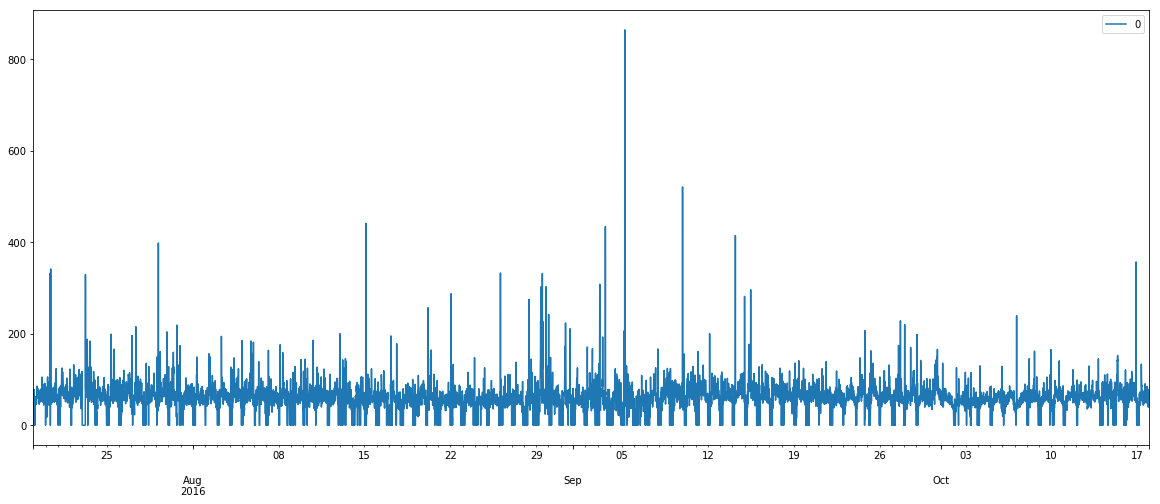

In [27]:
dta.plot(figsize=(20,8))
plt.show()

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)

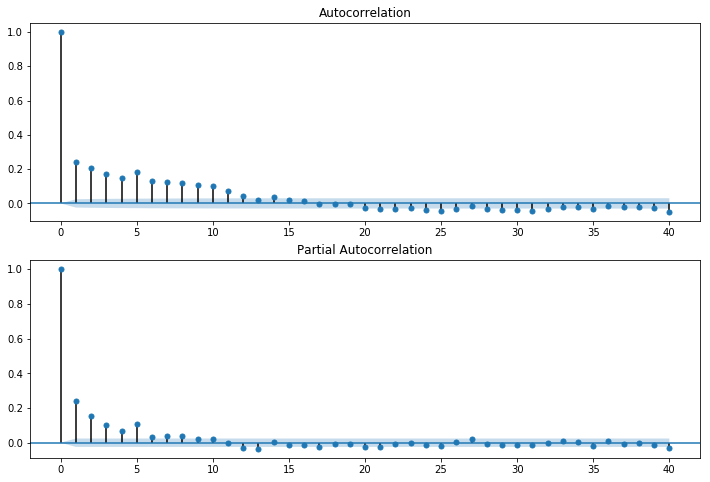

In [11]:
plt.show()

In [23]:
arma_mod20 = sm.tsa.ARMA(dta, (2,1)).fit()
arma_mod30 = sm.tsa.ARMA(dta, (3,2)).fit()
arma_mod10 = sm.tsa.ARMA(dta, (1,2)).fit()

In [24]:
arma_mod20.predict(start=6551,end=6700,dynamic=True)
#print arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic

2016-10-17 23:40:00    60.868867
2016-10-18 00:00:00    60.468120
2016-10-18 00:20:00    60.392638
2016-10-18 00:40:00    60.330346
2016-10-18 01:00:00    60.274921
2016-10-18 01:20:00    60.225530
2016-10-18 01:40:00    60.181514
2016-10-18 02:00:00    60.142289
2016-10-18 02:20:00    60.107333
2016-10-18 02:40:00    60.076181
2016-10-18 03:00:00    60.048419
2016-10-18 03:20:00    60.023679
2016-10-18 03:40:00    60.001632
2016-10-18 04:00:00    59.981984
2016-10-18 04:20:00    59.964474
2016-10-18 04:40:00    59.948870
2016-10-18 05:00:00    59.934965
2016-10-18 05:20:00    59.922572
2016-10-18 05:40:00    59.911529
2016-10-18 06:00:00    59.901687
2016-10-18 06:20:00    59.892917
2016-10-18 06:40:00    59.885101
2016-10-18 07:00:00    59.878135
2016-10-18 07:20:00    59.871928
2016-10-18 07:40:00    59.866396
2016-10-18 08:00:00    59.861466
2016-10-18 08:20:00    59.857073
2016-10-18 08:40:00    59.853158
2016-10-18 09:00:00    59.849669
2016-10-18 09:20:00    59.846560
          

In [14]:
sm.stats.durbin_watson(arma_mod30.resid.values)

2.0135160598702382

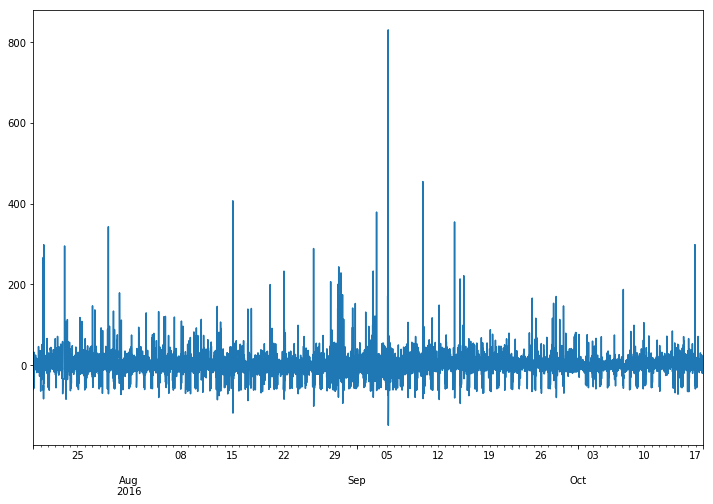

In [15]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax);
plt.show()

In [16]:

resid = arma_mod30.resid
resid

2016-07-19 00:00:00   -59.843396
2016-07-19 00:20:00    12.737273
2016-07-19 00:40:00   -50.273515
2016-07-19 01:00:00   -42.229397
2016-07-19 01:20:00    16.548349
2016-07-19 01:40:00    32.431440
2016-07-19 02:00:00   -56.847352
2016-07-19 02:20:00    -7.914463
2016-07-19 02:40:00   -10.230357
2016-07-19 03:00:00   -47.812153
2016-07-19 03:20:00    -2.204899
2016-07-19 03:40:00    -7.065731
2016-07-19 04:00:00     0.554358
2016-07-19 04:20:00     9.008370
2016-07-19 04:40:00   -10.547332
2016-07-19 05:00:00    -6.802259
2016-07-19 05:20:00    -1.448987
2016-07-19 05:40:00     1.933060
2016-07-19 06:00:00   -11.450751
2016-07-19 06:20:00    -7.954201
2016-07-19 06:40:00    10.907569
2016-07-19 07:00:00     6.395468
2016-07-19 07:20:00    25.140967
2016-07-19 07:40:00    -7.109447
2016-07-19 08:00:00    17.997384
2016-07-19 08:20:00    13.756814
2016-07-19 08:40:00    -3.073543
2016-07-19 09:00:00    12.627405
2016-07-19 09:20:00     3.213573
2016-07-19 09:40:00     5.282799
          

In [17]:
stats.normaltest(resid)

NormaltestResult(statistic=7168.9091566695806, pvalue=0.0)

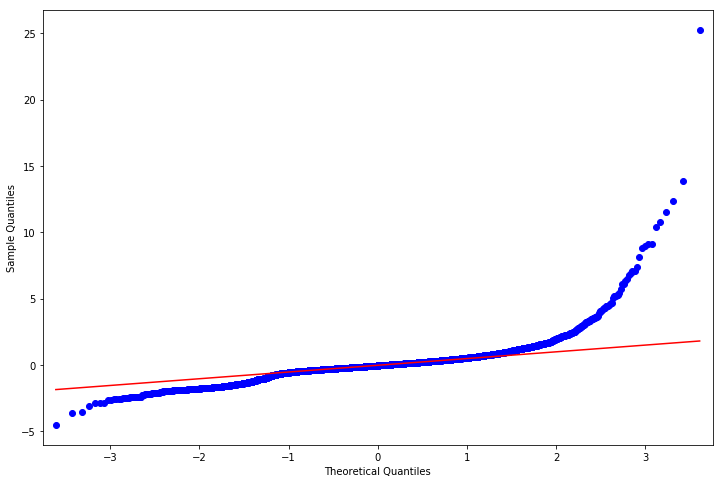

In [18]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

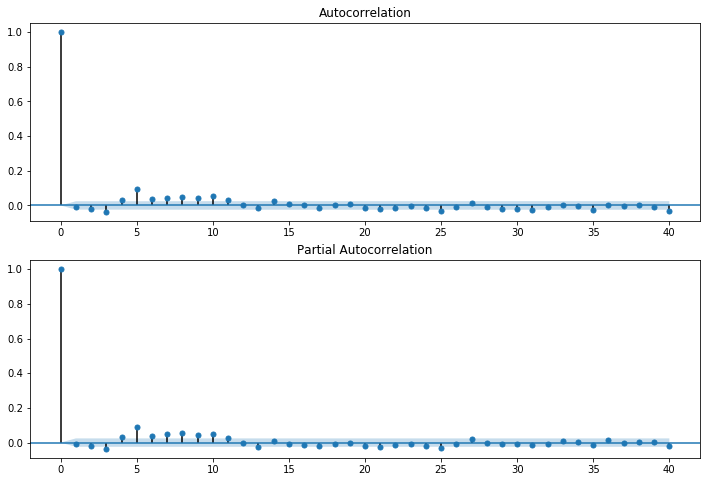

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

In [20]:
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pandas.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print table.set_index('lag')

            AC           Q      Prob(>Q)
lag                                     
1.0  -0.007039    0.324783  5.687475e-01
2.0  -0.021253    3.286185  1.933811e-01
3.0  -0.035521   11.559358  9.055637e-03
4.0   0.030639   17.715580  1.402459e-03
5.0   0.092326   73.625574  1.800299e-14
6.0   0.034531   81.447455  1.794302e-15
7.0   0.043712   93.983639  1.876765e-17
8.0   0.046181  107.978166  9.907254e-20
9.0   0.041917  119.509772  1.683432e-21
10.0  0.052171  137.375993  1.452611e-24
11.0  0.029217  142.980188  4.030042e-25
12.0  0.000988  142.986600  1.492834e-24
13.0 -0.014674  144.400602  2.757046e-24
14.0  0.023559  148.045967  1.767092e-24
15.0  0.009097  148.589562  4.596739e-24
16.0  0.005422  148.782702  1.357512e-23
17.0 -0.012309  149.778352  2.704753e-23
18.0  0.002899  149.833591  8.006737e-23
19.0  0.008264  150.282488  1.933112e-22
20.0 -0.015363  151.834159  2.798222e-22
21.0 -0.020953  154.720756  2.215340e-22
22.0 -0.012632  155.770129  3.876982e-22
23.0 -0.003811  